<a href="https://colab.research.google.com/github/kevyntoro29/pneumothorax_segmentation/blob/main/pneumothorax_segmentation_npy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Sep  3 15:47:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#**HYPERPARAMMERS**

In [ ]:
import tensorflow as tf
tf.autograph.set_verbosity(1)
tf.random.set_seed(1)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8)
session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [ ]:
img_size = 256 
h = 256
w = 256
batch_size = 16 #32 
channels = 1 

#**DRIVE AND LIBRARIES**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from glob import glob
import pandas as pd
from tqdm import tqdm
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [ ]:
'''from https://github.com/sneddy/pneumothorax-segmentation'''

from albumentations import (Compose, HorizontalFlip, CLAHE, HueSaturationValue, RandomBrightness, RandomContrast, RandomGamma,
                            OneOf, ToFloat, ShiftScaleRotate, GridDistortion, ElasticTransform, JpegCompression, Resize,
                            HueSaturationValue, RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, 
                            GaussNoise,CenterCrop, IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop)

AUGMENTATIONS_TRAIN = Compose([HorizontalFlip(p=0.5), 
                               OneOf([RandomContrast(), RandomGamma(), RandomBrightness(),], p=0.3), 
                               OneOf([ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03), GridDistortion(),
                                      OpticalDistortion(distort_limit=2, shift_limit=0.5),], p=0.3), 
                               RandomSizedCrop(min_max_height=(128, 256), height=h, width=w,p=0.25), ToFloat(max_value=1)], p=1)

AUGMENTATIONS_TEST = Compose([ToFloat(max_value=1)], p=1)

In [49]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Add, Flatten
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [50]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
import tensorflow.keras.utils as conv_utils
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import multiply
from tensorflow.keras import optimizers

#**LOAD DATASET FROM NPY**

In [ ]:
X_train_path = '/content/drive/MyDrive/Dataset_npy_1/X_train.npy'
y_train_path = '/content/drive/MyDrive/Dataset_npy_1/y_train.npy'

X_val_path = '/content/drive/MyDrive/Dataset_npy_1/X_val.npy'
y_val_path = '/content/drive/MyDrive/Dataset_npy_1/y_val.npy'

In [ ]:
X_train = np.load(X_train_path)
y_train = np.load(y_train_path)

X_val = np.load(X_val_path)
y_val = np.load(y_val_path)

Text(0.5, 1.0, '(0, 255)')

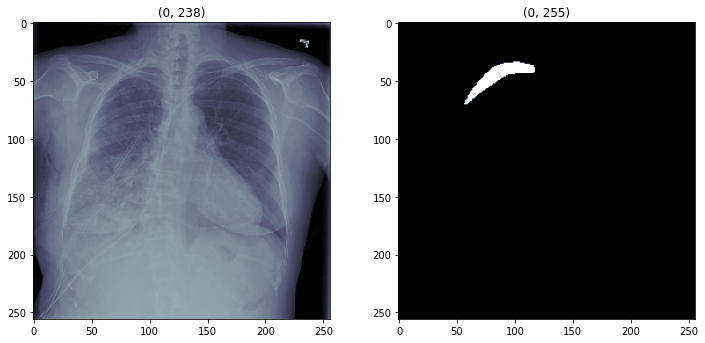

In [ ]:
d = 1
rango_X = np.amin(X_train[d]),np.amax(X_train[d])
rango_y = np.amin(y_train[d]),np.amax(y_train[d])
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(X_train[d], cmap=plt.cm.bone)
ax1.set_title(rango_X)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(y_train[d], cmap = plt.cm.bone)
ax2.set_title(rango_y)

#**DATAGEN**

In [ ]:
'''from https://www.kaggle.com/mbermejoa/tfm-codigo-mbermejoa'''
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, X_data, y_data, augmentations=None, 
                 batch_size=batch_size, img_size=256, channels=channels, shuffle=True):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.img_size = img_size
        self.channels = channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.X_data)) / self.batch_size)
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.X_data))]
        X_data_temp = [self.X_data[k] for k in indexes]
        y_data_temp = [self.y_data[m] for m in indexes]

        X, y = self.data_generation(X_data_temp, y_data_temp)
        
        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255
            
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X_data))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def data_generation(self, X_data_temp, y_data_temp):
        X = np.empty((len(X_data_temp),self.img_size,self.img_size, self.channels))
        y = np.empty((len(X_data_temp),self.img_size,self.img_size, self.channels))

        for idx, X_data_img in enumerate(X_data_temp): 
            X[idx,] = np.expand_dims(X_data_img, axis=2)

        for idx, y_data_img in enumerate(y_data_temp):
            y[idx,] = np.expand_dims(y_data_img, axis=2)

        X = np.uint8(X)
        y = np.uint8(y)
        return X, y

(64, 256, 256, 1) (64, 256, 256, 1)


Text(0.5, 0.98, 'Radiografías toráx: con neumotórax en amarillo.')

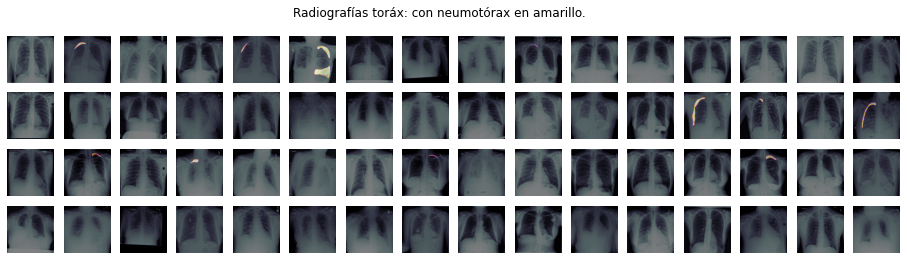

In [44]:
gen_norm = DataGen(X_train, y_train, batch_size=64, shuffle=False)
x,y = gen_norm.__getitem__(0)
print(x.shape, y.shape)
max_imagenes = 64
grid_width = 16
grid_height = int(max_imagenes / grid_width)

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(x, y)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap=plt.cm.bone)
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="inferno")    
    ax.axis('off')

plt.suptitle("Radiografías toráx: con neumotórax en amarillo.")

uint8
(256, 256, 1)


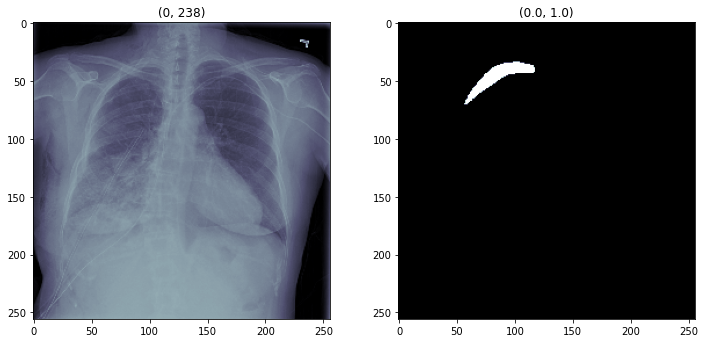

In [45]:
d = 1
rango_X = np.amin(x[d]),np.amax(x[d])
rango_y = np.amin(y[d]),np.amax(y[d])
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(x[d][:,:,0], cmap=plt.cm.bone)
ax1.set_title(rango_X)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(y[d][:,:,0], cmap = plt.cm.bone)
ax2.set_title(rango_y)
print(x[d].dtype)
print(x[d].shape)

(64, 256, 256, 1) (64, 256, 256, 1)


Text(0.5, 0.98, "Radiografías 'albumentations': con neumotórax en amarillo.")

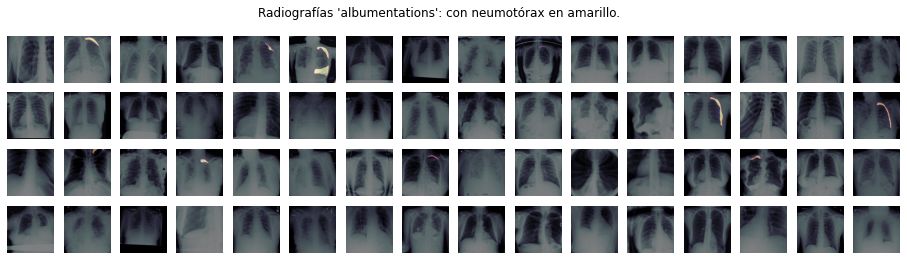

In [39]:
gen_albu = DataGen(X_train, y_train, batch_size=64, augmentations=AUGMENTATIONS_TRAIN, shuffle=False)
x, y = gen_albu.__getitem__(0)
print(x.shape, y.shape)

max_imagenes = 64
grid_width = 16
grid_height = int(max_imagenes / grid_width)

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(x, y)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap=plt.cm.bone)
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="inferno")    
    ax.axis('off')
    
plt.suptitle("Radiografías 'albumentations': con neumotórax en amarillo.")

float32
(256, 256, 1)


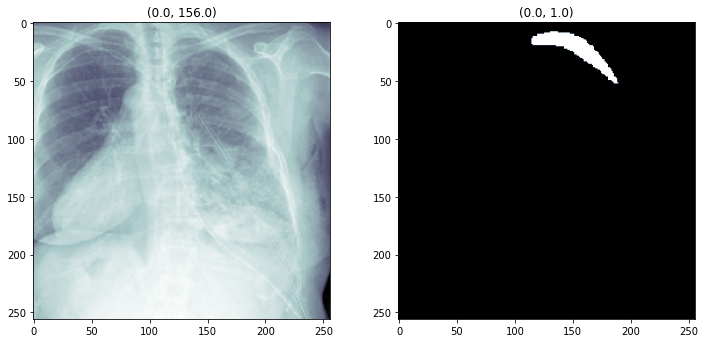

In [43]:
d = 1
rango_X = np.amin(x[d]),np.amax(x[d])
rango_y = np.amin(y[d]),np.amax(y[d])
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(x[d][:,:,0], cmap=plt.cm.bone)
ax1.set_title(rango_X)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(y[d][:,:,0], cmap = plt.cm.bone)
ax2.set_title(rango_y)
print(x[d].dtype)
print(x[d].shape)

#**METRICS**

In [46]:
'''from https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow'''

def get_iou_vector(A, B):   
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        if true == 0:
            metric += (pred == 0)
            continue
        
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [47]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = Flatten()(y_true)
    y_pred_f = Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
    

#**UNET-RESNET34 MODEL**

In [51]:
'''from https://github.com/rytisss/RoadPavementSegmentation/blob/c0c25d8d3e04e13f62659ccc387ac769556c3414/models/layers.py#L696'''
def AtrousSpatialPyramidPoolCoordConv(input,
                          kernels=8,
                          kernel_size=3,
                          useLeakyReLU=False,
                          leakyReLU_alpha=0.3):

    # dilate = 1
    #input_coord_1 = AddCoords2D()(input)
    input_coord_1 = input
    dilate1 = Conv2D(kernels, kernel_size, padding='same', dilation_rate=1, kernel_initializer='he_normal')(input_coord_1)
    dilate1 = tf.keras.layers.BatchNormalization()(dilate1)
    if useLeakyReLU:
        dilate1 = LeakyReLU(alpha=leakyReLU_alpha)(dilate1)
    else:
        dilate1 = tf.keras.layers.Activation('relu')(dilate1)

    # dilate = 2
    #input_coord_2 = AddCoords2D()(input)
    input_coord_2 = input
    dilate2 = Conv2D(kernels, kernel_size, padding='same', dilation_rate=2, kernel_initializer='he_normal')(input_coord_2)
    dilate2 = tf.keras.layers.BatchNormalization()(dilate2)
    if useLeakyReLU:
        dilate2 = LeakyReLU(alpha=leakyReLU_alpha)(dilate2)
    else:
        dilate2 = tf.keras.layers.Activation('relu')(dilate2)

    # dilate = 3
    #input_coord_3 = AddCoords2D()(input)
    input_coord_3 = input
    dilate3 = Conv2D(kernels, kernel_size, padding='same', dilation_rate=4, kernel_initializer='he_normal')(input_coord_3)
    dilate3 = tf.keras.layers.BatchNormalization()(dilate3)
    if useLeakyReLU:
        dilate3 = LeakyReLU(alpha=leakyReLU_alpha)(dilate3)
    else:
        dilate3 = tf.keras.layers.Activation('relu')(dilate3)

    H, W, n_ch = input.shape.as_list()[1:]
    pool = tf.keras.layers.AveragePooling2D(pool_size=(H, W))(input)
    pool = UpSampling2D((H, W), interpolation='bilinear')(pool)

    # pool
    #pool = AveragePooling2D(pool_size=(3, 3), strides=(1,1), padding='same')(input)
    #averaged_pool = Conv2D(kernels, 1, strides=(1,1), padding='same', kernel_initializer='he_normal')(input)
    #conv = BatchNormalization()(conv)
    #conv = Activation('relu')(conv)

    output = Concatenate()([dilate1, dilate2, dilate3, pool])

    #perform parameters reduction with 1x1
    #output = AddCoords2D()(output)
    output = output
    output = Conv2D(kernels, kernel_size=(1, 1), strides=1, padding='same',
                    kernel_initializer='he_normal')(output)
    output = tf.keras.layers.BatchNormalization()(output)
    if useLeakyReLU:
        output = LeakyReLU(alpha=leakyReLU_alpha)(output)
    else:
        output = tf.keras.layers.Activation('relu')(output)

    return output

In [ ]:
def bn_act(x, act=True):
    'batch normalization layer with an optinal activation layer'
    x = tf.keras.layers.BatchNormalization()(x)
    if act == True:
        x = tf.keras.layers.Activation('relu')(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    'convolutional layer which always uses the batch normalization layer'
    conv = bn_act(x)
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    conv = Conv2D(filters, kernel_size=kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [ ]:
def ResUNet(img_size):
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_size, img_size, channels))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    #AtrousSpatialPyramidPoolCoordConv

    aspp = AtrousSpatialPyramidPoolCoordConv(b1)

    ## Decoder
    u1 = upsample_concat_block(aspp, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [ ]:
import os
os.mkdir("/content/drive/MyDrive/model_callback")
checkpoint_filepath = './model_callback_1'

In [ ]:
'''from https://www.kaggle.com/meaninglesslives/unet-with-efficientnet-encoder-in-keras'''
# SnapshotModelCheckpoint(Callback): guarda los pesos de las instantáneas del modelo.
# Guarda los pesos del modelo en determinadas épocas (que pueden considerarse la instantánea del modelo en esa época).
# Debe usarse con el programa de velocidad de aprendizaje 'cosine anneal' para ahorrar peso justo antes de que la velocidad de
# aprendizaje aumente drásticamente.

class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):
        checkpoint_filepath = './keras.model'
        model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
                                                                        monitor='val_my_iou_metric', mode = 'max', 
                                                                        save_best_only=True, verbose=1), 
                                     callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)]
        return model_checkpoint_callback

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [ ]:
tf.keras.backend.clear_session()
model_iou = ResUNet(img_size)
adam = tf.keras.optimizers.Adam(lr = 0.0001, epsilon = 0.001)
model_iou.compile(optimizer=adam, loss=bce_dice_loss, metrics=[my_iou_metric])
model_iou.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
parameters = {'img_size': img_size,
              'batch_size': batch_size,
              'channels': channels,
              'shuffle': True}
epochs = 150

# SnapshotModelCheckpoint(Callback): guarda los pesos de las instantáneas del modelo.
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs, nb_snapshots=1, init_lr=0.001)

# Generación de datos para los datos de entrenamiento y los de validación.
training_generator_model_iou = DataGen(X_train, y_train, augmentations=AUGMENTATIONS_TRAIN, **parameters)
validation_generator_model_iou = DataGen(X_val, y_val, augmentations=AUGMENTATIONS_TEST,  **parameters)

# Números de pasos de entrenamiento.
train_steps = len(X_train)//batch_size
# Números de pasos de validación.
val_steps = len(X_val)//batch_size

# Entrenamiento del modelo con métrica: IoU.
history_model_iou = model_iou.fit_generator(generator=training_generator_model_iou, validation_data=validation_generator_model_iou,
                                            steps_per_epoch=train_steps, validation_steps=val_steps, use_multiprocessing=False, 
                                            epochs=epochs, verbose=1, callbacks=snapshot.get_callbacks())



INFO:tensorflow:Converted call: <function DatasetV2.from_generator.<locals>.flat_map_fn at 0x7fd144998320>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function DatasetV2.from_generator.<locals>.get_iterator_id_fn at 0x7fd13ec73cb0>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function DatasetV2.from_generator.<locals>.generator_next_fn at 0x7fd13ec73dd0>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function DatasetV2.from_generator.<locals>.finalize_fn at 0x7fd144998d40>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
INFO:tensorflow:Converted call: <function Model.make_train_function.<locals>.train_function at 0x7fd13ec42ef0>
    args: (<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7fd13ebc5b10>,)
    kwargs: {}

INFO:tensorflow:<function Model.make_train_function.<locals>.train_function at 0x7fd13ec42ef0> is not cached for subkey ConversionOptions[{}]
INFO:tensorflow:Converted call: <function Model.make_train_function.<locals>.step_function at 0x7fd13ffa5710>
    args: (<keras.engine.functional.Functional object at 0x7fd13ecbf850>, <tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7fd13ebc5b10>)
    kwargs: None

INFO:tensorflow:Converted call: <function Model.make_train_function.<locals>.step_function.<locals>.run_step at 0x7fd13ec3ccb0>
    args: ((<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None, None, None) dtype=float32>),)
    kwargs: {}

INFO:tensorflow:Converted c

dict_keys(['loss', 'my_iou_metric', 'val_loss', 'val_my_iou_metric', 'lr'])


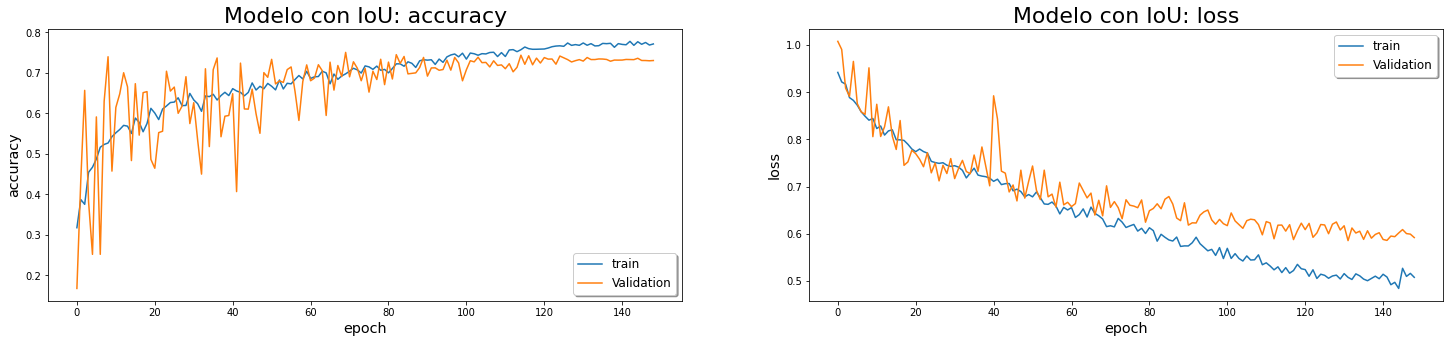

In [ ]:
plt.figure(figsize=(25, 5))

#ACCURACY
plt.subplot(1,2,1)
plt.plot(history_model_iou.history['my_iou_metric'][1:])
plt.plot(history_model_iou.history['val_my_iou_metric'][1:])
plt.title('Modelo con IoU: accuracy', fontsize = 22)
plt.ylabel('accuracy', fontsize = "x-large")
plt.xlabel('epoch', fontsize = "x-large")
plt.legend(['train', 'Validation'], loc = "best", fontsize = "large", shadow = 1, facecolor = "inherit")

#LOSS
plt.subplot(1,2,2)
plt.plot(history_model_iou.history['loss'][1:])
plt.plot(history_model_iou.history['val_loss'][1:])
plt.title('Modelo con IoU: loss', fontsize = 22)
plt.ylabel('loss', fontsize = "x-large")
plt.xlabel('epoch', fontsize = "x-large")
plt.legend(['train', 'Validation'], loc = "best", fontsize = "large", shadow = 1, facecolor = "inherit")

#gc.collect()
plt.show()

#**SAVE ACCURACY AND LOSS CURVES**

In [ ]:
np.save('my_history.npy',history_model_iou.history)

In [57]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [58]:
print(history.keys())

dict_keys(['loss', 'my_iou_metric', 'val_loss', 'val_my_iou_metric', 'lr'])


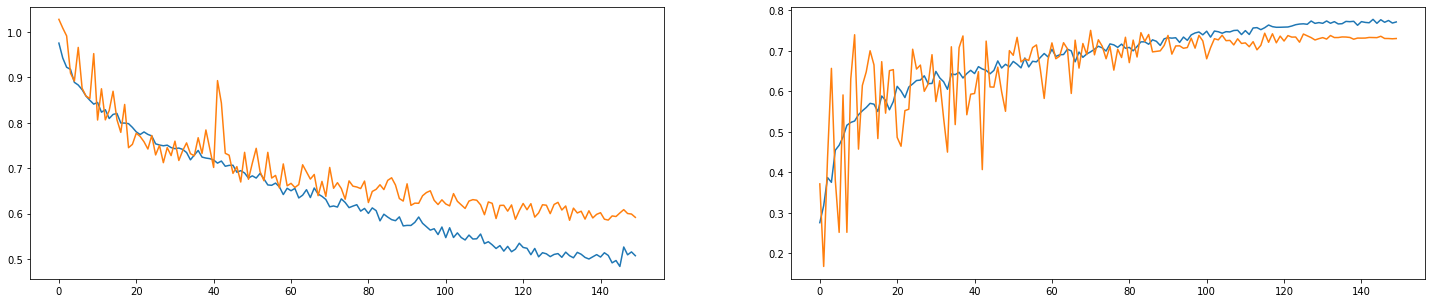

In [62]:
plt.figure(figsize=(25, 5))
plt.subplot(1,2,1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.subplot(1,2,2)
plt.plot(history['my_iou_metric'])
plt.plot(history['val_my_iou_metric'])